In [1]:
# Overall goal: predict the price of a house.
# Learn from housing data.
# Labels: median price for a house in this county (or some geographical region).
# Features: statistics like median income for the same county.

# Explore:
# The data types.
# Scaling - data ranges.
# Missing data.
# Correlations - redundant features.
# Combination features with more predictive power.
# Avoid too much examination as that leads to snooping bias.

import pandas as pd
datapath="/Users/jasonmiller/Source/MachineLearning/datasets/housing/housing.csv"
all_data=pd.read_csv(datapath)
# Look at the first few rows.
all_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
# Look at data types.
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
# Look for missing values.
all_data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [4]:
# Discover issue of missing data.
all_data["total_bedrooms"].isnull().sum()

207

In [5]:
# Look at statistics.
all_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
# Values and counts for the column that is categorical and non-numeric.
all_data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# Histogram for one numerical feature.
all_data["total_bedrooms"].value_counts()

280.0     55
331.0     51
345.0     50
393.0     49
343.0     49
          ..
2205.0     1
1448.0     1
1691.0     1
2537.0     1
2546.0     1
Name: total_bedrooms, Length: 1923, dtype: int64

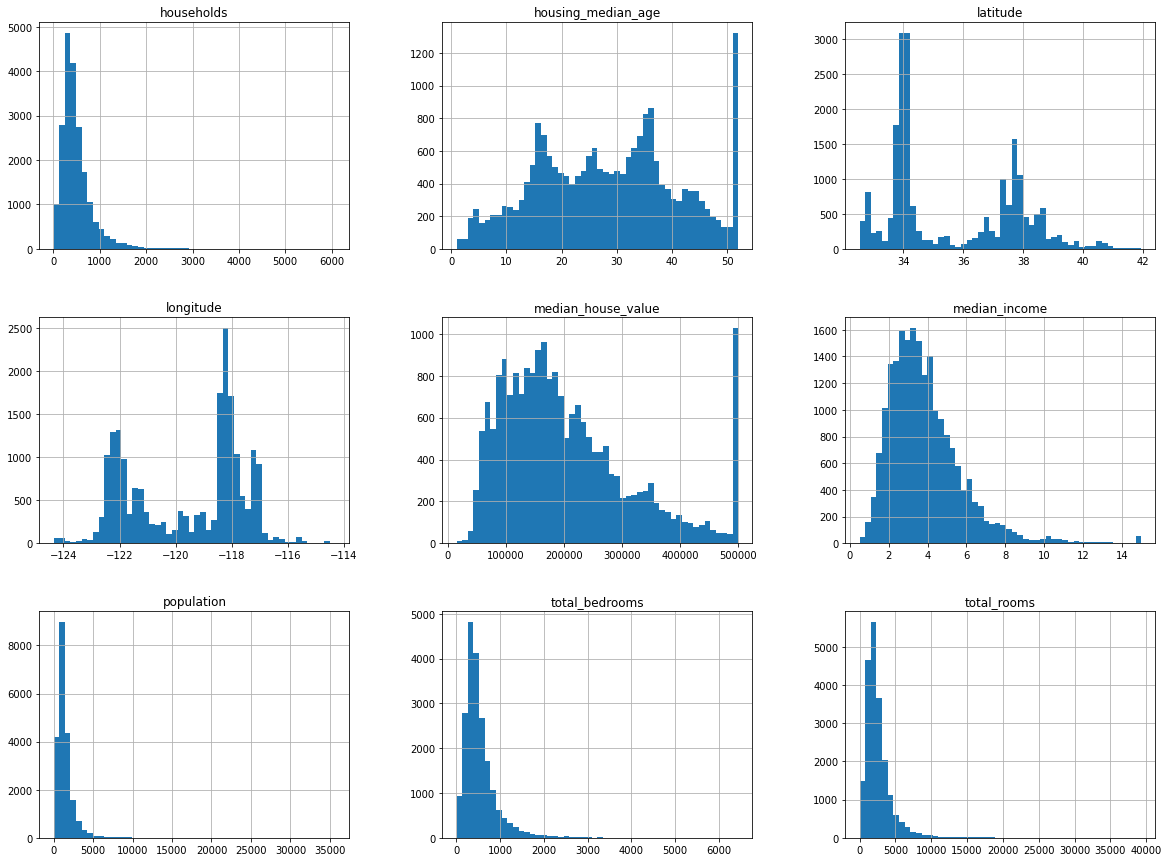

In [8]:
# Histograms for all features.
%matplotlib inline
import matplotlib.pyplot as plt
all_data.hist(bins=50,figsize=(20,15))
plt.show()
# Problem 1: 
# Some fields are capped i.e. all higher values were stuffed into max category.
# See vertical bars in housing_median_age, median_house_value, median_income.
# Problem 2: 
# Some fields are scaled e.g. income is fit to range of (0-1600).
# Problem 3:
# Every column has a different scale.
# Problem 4:
# Many fields have skew -- long right tails -- mean is inappropriate.

In [9]:
# Observation.
# Many high income brackets have few data points.
# A random partition to train/test could have sampling bias.
all_data["median_income"].value_counts()

3.1250     49
15.0001    49
2.8750     46
4.1250     44
2.6250     44
           ..
4.1514      1
1.2614      1
2.0294      1
6.7079      1
3.7306      1
Name: median_income, Length: 12928, dtype: int64

In [12]:
# Introduce a new feature: income bin (categorical) to replace income (float).
# This is just temporary. Remove this column later.
# Note if we add a column to all_data, the drop() command will not alter all_data (it returns another copy).
# So, unlike the book, use a temp table here.
import numpy as np
temp = all_data.copy()
temp["value_cat"]=pd.cut(all_data["median_income"],
                              bins=[0.0,1.5,3.0,4.5,6.0,np.inf],
                              labels=[1,2,3,4,5])
temp["value_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: value_cat, dtype: int64

In [15]:
# We hope to see 4% end up in the train and test sets.
temp["value_cat"].value_counts()[1]/len(temp["value_cat"])

0.039825581395348836

In [16]:
# Attribute combinations.
# Invent new features as combinations of existing features.
temp["rooms_per_household"]=temp["total_rooms"]/temp["households"]
temp["bedrooms_per_room"]=temp["total_bedrooms"]/temp["total_rooms"]
temp["population_per_household"]=temp["population"]/temp["households"]
# Look at correlation of new features.
# Rooms per household correlates with county median income.
temp[temp.columns[5:]].corr(method="spearman")

,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
population,1.000000,0.903872,0.006268,0.003839,-0.105385,0.072503,0.242337
households,0.903872,1.000000,0.030305,0.112737,-0.111115,0.097036,-0.138625
median_income,0.006268,0.030305,1.000000,0.676778,0.643671,-0.744571,-0.044171
median_house_value,0.003839,0.112737,0.676778,1.000000,0.263367,-0.331693,-0.256594
rooms_per_household,-0.105385,-0.111115,0.643671,0.263367,1.000000,-0.888021,0.018807
bedrooms_per_room,0.072503,0.097036,-0.744571,-0.331693,-0.888021,1.000000,-0.080145
population_per_household,0.242337,-0.138625,-0.044171,-0.256594,0.018807,-0.080145,1.000000


In [17]:
# Alternate view of correlation.
temp.corr()["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

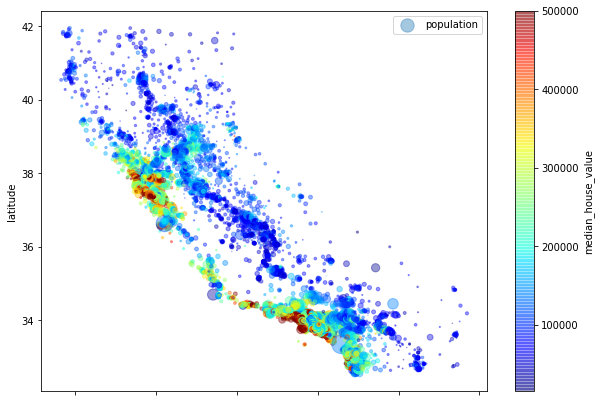

In [18]:
# Visualize geographically.
# Size(s)=pop. Color(c)=prices. (x,y)=map coords.
import matplotlib.pyplot as plt
all_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7),
        s=all_data["population"]/100, label="population", 
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

In [ ]:
# Observation: proximity to coast looks critical in south and middle but not north.